In [2]:
%load_ext autoreload
%autoreload 2

import sys         
sys.path.append('./../../src/') 
from data.ptbxl import create_dataset, get_feats_from_all_channels, load_ptbxl_data
from pathlib import Path
from signals.ecg import ECGSignal
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from signals.utils import parse_nested_feats
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed

TARGET = 'diagnostic_class'
DATASET_PATH = Path("./../../data/ptbxl")
SAMPLING_RATE = 100

In [3]:
ptbxl_data = load_ptbxl_data(
    sampling_rate=SAMPLING_RATE,
    path = DATASET_PATH,
    target = TARGET
)

In [2]:
ptbxl_dataset = create_dataset()

train split:   0%|          | 0/12978 [00:00<?, ?it/s]

val split:   0%|          | 0/1642 [00:00<?, ?it/s]

test split:   0%|          | 0/1652 [00:00<?, ?it/s]

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

# model = SVC(probability=True)
model = LGBMClassifier()


X_train = ptbxl_dataset['train']['X']
y_train = ptbxl_dataset['train']['y']

X_val = ptbxl_dataset['val']['X']
y_val = ptbxl_dataset['val']['y']

X_test = ptbxl_dataset['test']['X']
y_test = ptbxl_dataset['test']['y']

model.fit(X_train, y_train)

LGBMClassifier()

In [175]:
save_as_torch_and_npy_files()

In [41]:
from evaluation.metrics import get_classification_metrics
from evaluation.visualisations import plot_feature_importance, plot_confusion_matrix

train_metrics = get_classification_metrics(model.predict_proba(X_train), y_train)
val_metrics = get_classification_metrics(model.predict_proba(X_val), y_val)
test_metrics = get_classification_metrics(model.predict_proba(X_test), y_test)

In [42]:
val_metrics, test_metrics

({'fscore': 0.6247407970724964,
  'acc': 0.7576323987538941,
  'auc': 0.919570282475384},
 {'fscore': 0.6511467628590049,
  'acc': 0.7808814400993171,
  'auc': 0.9213483635956324})

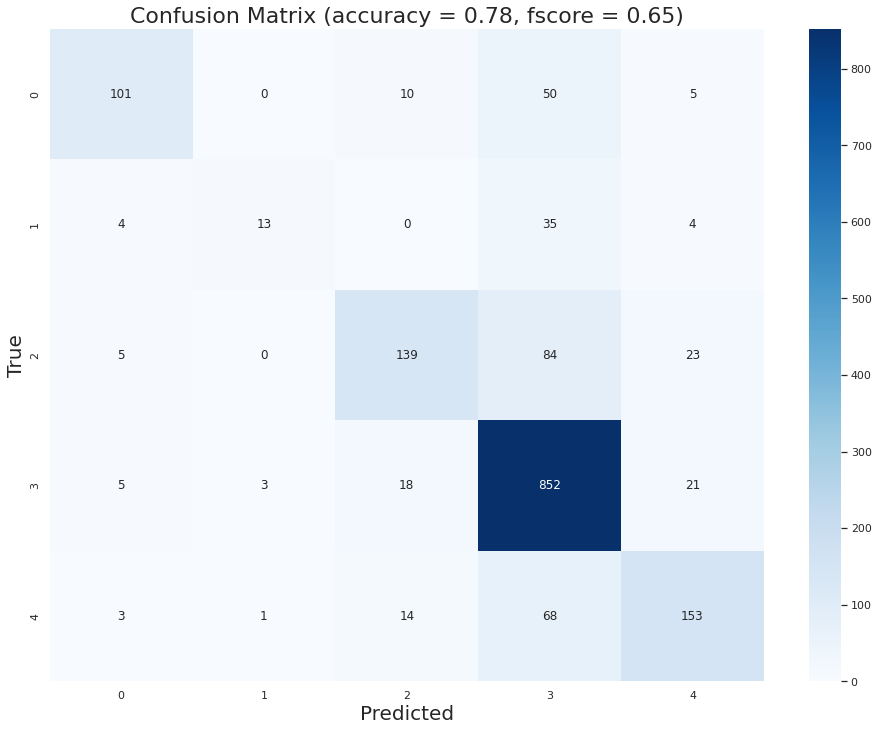

In [43]:
plot_confusion_matrix(y_test, model.predict(X_test), np.unique(y_train))

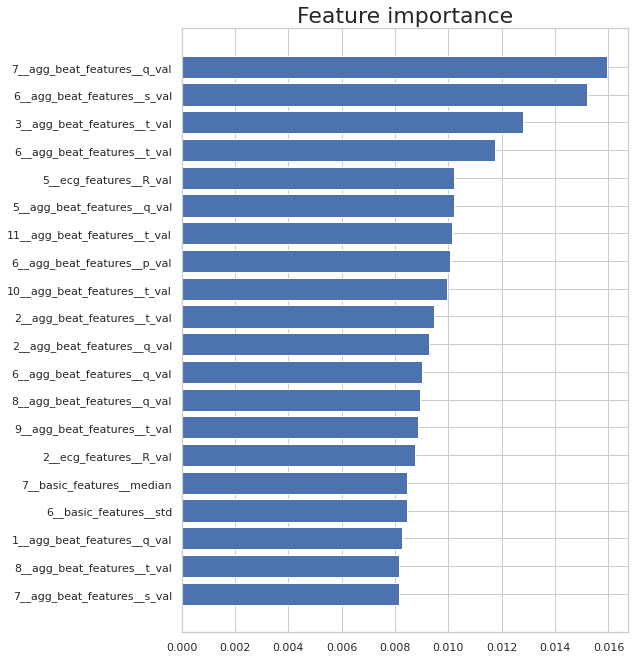

In [44]:
plot_feature_importance(X_train.columns.values, model.feature_importances_, n_best=20)

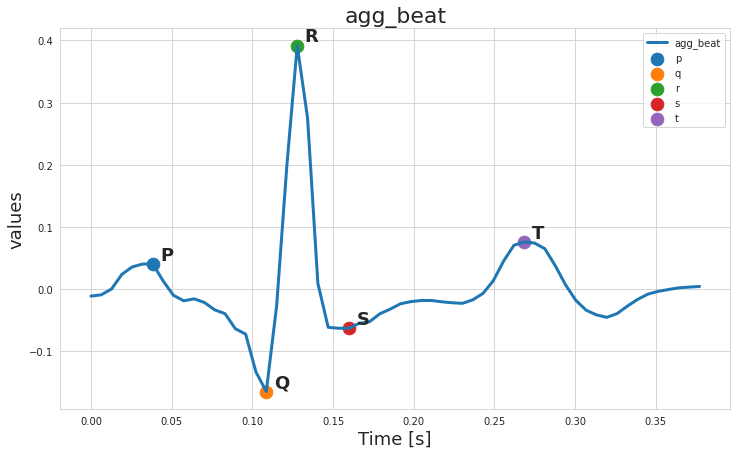

In [7]:
data = ptbxl_data['train']['X'][111, :, 0]
sig = ECGSignal("ecg", data, 100)
# sig.plot()
secg = sig.aggregate()
secg.plot_crit_points()

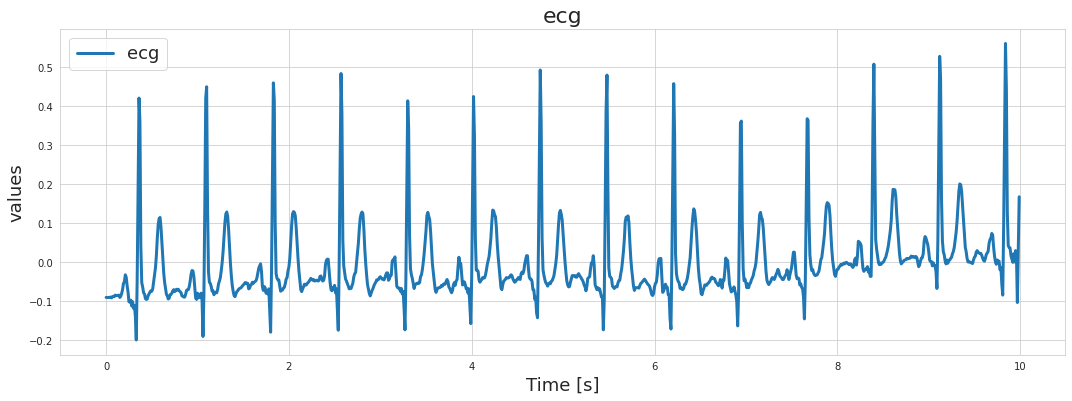

In [10]:
data = ptbxl_data['train']['X'][1111, :, 0]
sig.plot()

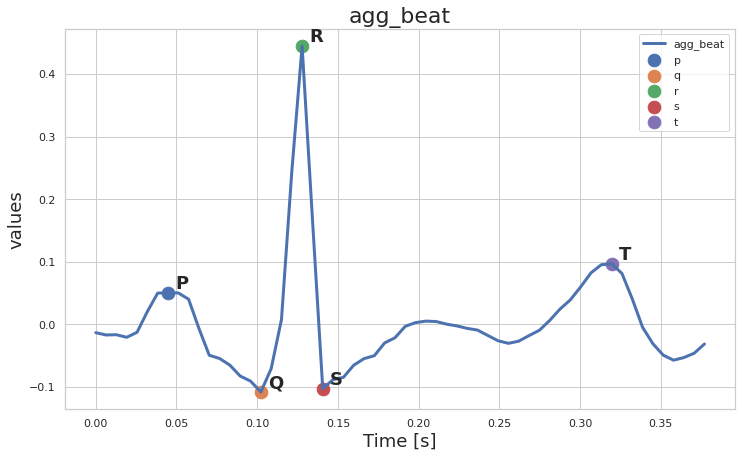

In [84]:
data = ptbxl_data['train']['X'][1111, :, 0]
sig = ECGSignal("ecg", data, 100)
# sig.plot()
secg = sig.aggregate()
secg.plot_crit_points()

In [42]:
from torch import nn
import torch

class MLP(nn.Module):
    def __init__(self, in_size=1000, n_classes=5):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            nn.ReLU(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_size // 4, n_classes)
        )
        
    def forward(self, x):
        out = self.model(x)
        probs = F.softmax(out, dim=1)
        if torch.any(probs.isnan()) or torch.any(probs.isinf()):
            print(out)
        return probs
        

In [45]:
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
from evaluation.metrics import get_classification_metrics


class PTBXLWaveFormClassifier(LightningModule):
    def __init__(self, in_dims, classifier: nn.Module, learning_rate: float = 1e-3):
        super().__init__()
        self.classifier = classifier
        self.learning_rate = learning_rate
        self.save_hyperparameters('in_dims', 'learning_rate')
    
    def forward(self, x):
        return self.classifier(x)

    def _common_step(self, batch, batch_ids, stage, log=True):
        x, labels = batch
        probs = self(x)
        log_probs = torch.log(probs)
        preds = log_probs.argmax(axis=1)
        if log:
            y_pred_proba = probs.detach().numpy()
            metrics = get_classification_metrics(y_pred_proba, labels, labels=np.arange(5), auc=stage in ('val', 'test'))
            for metric, val in metrics.items():
                self.log(f"{stage}/{metric}", val, on_step=False, on_epoch=True)
        return labels, probs, log_probs, preds
        
    def training_step(self, batch, batch_idx):
        labels, probs, log_probs, preds = self._common_step(batch, batch_idx, 'train', log=True)
        loss = F.nll_loss(log_probs, labels)
        return loss
    
    def validation_step(self, batch, batch_idx):
        labels, probs, log_probs, preds = self._common_step(batch, batch_idx, 'val', log=True)
        loss = F.nll_loss(log_probs, labels)
        return log_probs
    
    def predict_step(self, batch, batch_idx):
        _, _, _, preds = self._common_step(batch, batch_idx, 'predict', log=False)
        return preds

    def test_step(self, batch, batch_idx):
        _, _, _, preds = self._common_step(batch, batch_idx, 'test', log=False)
        return preds
    
    def test_epoch_end(self, test_step_outputs):  # args are defined as part of pl API
        dummy_input = torch.zeros(self.hparams["in_dims"], device=self.device)
        model_filename = "model_final.onnx"
        self.to_onnx(model_filename, dummy_input, export_params=True)
        wandb.save(model_filename)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-3)

In [46]:
from data.ptbxl import PTBXLWaveformDataModule

ptbxl_datamodule = PTBXLWaveformDataModule(
    sampling_rate=100, target='diagnostic_class', batch_size=64, num_workers=8
)

mlp = MLP()
model = PTBXLWaveFormClassifier(1000, mlp, learning_rate=1e-3)
trainer = Trainer()
trainer.fit(model, ptbxl_datamodule)

/home/shate/.local/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/shate/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name       | Type | Params
------------------------------------
0 | classifier | MLP  | 627 K 
------------------------------------
627 K     Trainable params
0         Non-trainable params
627 K     Total params
2.508     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, n

Validation: 0it [00:00, ?it/s]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').